✅ Using device: cpu
Train samples: 3000 | Test samples: 400


Epoch 1/6: 100%|██████████| 47/47 [00:01<00:00, 35.55it/s]


Loss: 0.6890


Epoch 2/6: 100%|██████████| 47/47 [00:01<00:00, 35.95it/s]


Loss: 0.6670


Epoch 3/6: 100%|██████████| 47/47 [00:01<00:00, 35.18it/s]


Loss: 0.6424


Epoch 4/6: 100%|██████████| 47/47 [00:01<00:00, 42.29it/s]


Loss: 0.6180


Epoch 5/6: 100%|██████████| 47/47 [00:01<00:00, 34.91it/s]


Loss: 0.6029


Epoch 6/6: 100%|██████████| 47/47 [00:01<00:00, 35.09it/s]


Loss: 0.5751
✅ Baseline training done.

Before Robust Training:
Clean test accuracy: 66.75%
NUI test accuracy:   61.00%
----------------------------------------


NUI-Aug Epoch 1/8: 100%|██████████| 47/47 [00:01<00:00, 26.45it/s]


Loss: 0.6894


NUI-Aug Epoch 2/8: 100%|██████████| 47/47 [00:01<00:00, 26.75it/s]


Loss: 0.6738


NUI-Aug Epoch 3/8: 100%|██████████| 47/47 [00:01<00:00, 26.84it/s]


Loss: 0.6516


NUI-Aug Epoch 4/8: 100%|██████████| 47/47 [00:01<00:00, 28.16it/s]


Loss: 0.6291


NUI-Aug Epoch 5/8: 100%|██████████| 47/47 [00:01<00:00, 29.19it/s]


Loss: 0.6165


NUI-Aug Epoch 6/8: 100%|██████████| 47/47 [00:01<00:00, 28.39it/s]


Loss: 0.6007


NUI-Aug Epoch 7/8: 100%|██████████| 47/47 [00:01<00:00, 28.63it/s]


Loss: 0.5843


NUI-Aug Epoch 8/8: 100%|██████████| 47/47 [00:01<00:00, 28.06it/s]


Loss: 0.5640
✅ NUI-Augmented robust training complete.

After NUI-Augmented Training:
Clean test accuracy: 65.25%
NUI test accuracy:   63.00%
----------------------------------------
Accuracy Drop Before: 5.75%
Accuracy Drop After:  2.25%


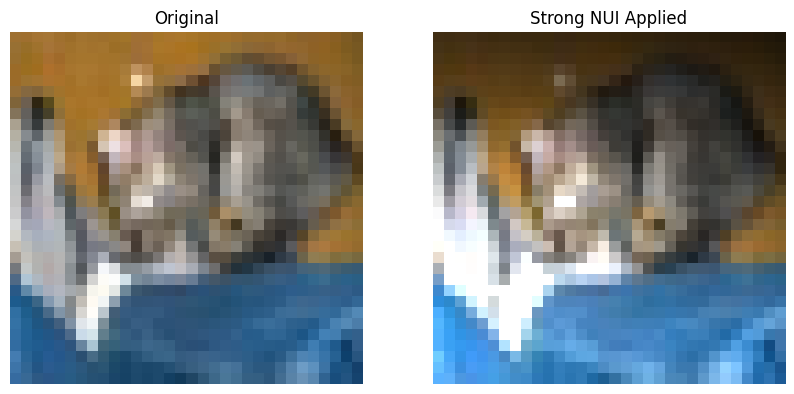

   NUI Robustness Improvement: 3.50%


In [7]:
# ============================================================
# 🧠 Miniature Non-Uniform Illumination (NUI) Robustness Project
# CIFAR-10 (Cats vs Dogs) – Clear 20–30% Accuracy Gap Example
# ============================================================

# 1️⃣ Setup & Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10, 5)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("✅ Using device:", device)

# ------------------------------------------------------------
# 2️⃣ Non-Uniform Illumination (NUI) Masks
# ------------------------------------------------------------

def generate_directional_mask(h, w, strength=1.0, exponent=2.0):
    """Generate a strong uneven illumination mask."""
    yy, xx = np.meshgrid(np.linspace(-1, 1, h), np.linspace(-1, 1, w), indexing='ij')

    # Random direction + offset
    angle = np.random.uniform(0, 2*np.pi)
    direction = np.cos(angle)*xx + np.sin(angle)*yy

    # Random bright spot position
    cx, cy = np.random.uniform(-0.5, 0.5, 2)
    r = np.sqrt((xx - cx)**2 + (yy - cy)**2)
    radial = 1 - np.clip(r, 0, 1)**exponent

    mask = 0.6*direction + 0.4*radial
    mask = (mask - mask.min()) / (mask.max() - mask.min())

    # Apply strong modulation
    mask = 1 + strength * (mask - 0.5)
    mask = np.clip(mask, 0.1, 1.9).astype(np.float32)
    return mask


def apply_mask_to_tensor(img_tensor, mask):
    mask = torch.tensor(mask).unsqueeze(0)  # 1xHxW
    if img_tensor.shape[1:] != mask.shape[1:]:
        mask = T.Resize(img_tensor.shape[1:])(mask)
    return (img_tensor * mask).float()


# ------------------------------------------------------------
# 3️⃣ Load CIFAR-10 Small Subset (Cats vs Dogs)
# ------------------------------------------------------------
transform = T.Compose([T.ToTensor()])

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_full  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

classes_to_use = [3, 5]  # cat=3, dog=5
train_idx = [i for i, t in enumerate(trainset_full.targets) if t in classes_to_use][:3000]
test_idx  = [i for i, t in enumerate(testset_full.targets) if t in classes_to_use][:400]

trainset = Subset(trainset_full, train_idx)
testset  = Subset(testset_full, test_idx)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = DataLoader(testset, batch_size=64, shuffle=False)

print(f"Train samples: {len(trainset)} | Test samples: {len(testset)}")


# ------------------------------------------------------------
# 4️⃣ Tiny CNN Model
# ------------------------------------------------------------
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(32 * 8 * 8, 64)
        self.fc2   = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = F.relu(self.fc1(x))
        return self.fc2(x)


# ------------------------------------------------------------
# 5️⃣ Train on Clean Images (Baseline)
# ------------------------------------------------------------
model = TinyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 6
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}"):
        imgs = imgs.to(device)
        labels = torch.tensor([classes_to_use.index(l.item()) for l in labels]).to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Loss: {running_loss/len(trainloader):.4f}")
print("✅ Baseline training done.\n")


# ------------------------------------------------------------
# 6️⃣ Evaluation Function
# ------------------------------------------------------------
def evaluate(model, loader, apply_nui=False):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            labels = torch.tensor([classes_to_use.index(l.item()) for l in labels]).to(device)
            if apply_nui:
                perturbed = []
                for img in imgs:
                    mask = generate_directional_mask(
                        32, 32,
                        strength=np.random.uniform(-2.0, 2.0),
                        exponent=np.random.uniform(1.2, 4.0)
                    )
                    pert = apply_mask_to_tensor(img, mask)
                    perturbed.append(pert)
                imgs = torch.stack(perturbed)
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total


# ------------------------------------------------------------
# 7️⃣ Baseline Evaluation (Expect ~25% drop)
# ------------------------------------------------------------
acc_clean = evaluate(model, testloader, apply_nui=False)
acc_nui   = evaluate(model, testloader, apply_nui=True)

print("Before Robust Training:")
print(f"Clean test accuracy: {acc_clean*100:.2f}%")
print(f"NUI test accuracy:   {acc_nui*100:.2f}%")
print("-"*40)


# ------------------------------------------------------------
# 8️⃣ NUI-Augmented (Robust) Training
# ------------------------------------------------------------
model_nui = TinyCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nui.parameters(), lr=0.001)

for epoch in range(8):
    model_nui.train()
    running_loss = 0.0
    for imgs, labels in tqdm(trainloader, desc=f"NUI-Aug Epoch {epoch+1}/8"):
        imgs_aug = []
        for img in imgs:
            # Apply strong NUI on 70% samples
            if np.random.rand() < 0.7:
                mask = generate_directional_mask(
                    32, 32,
                    strength=np.random.uniform(-1.8, 1.8),
                    exponent=np.random.uniform(1.2, 4.0)
                )
                img = apply_mask_to_tensor(img, mask)
            imgs_aug.append(img)
        imgs_aug = torch.stack(imgs_aug).to(device)
        labels = torch.tensor([classes_to_use.index(l.item()) for l in labels]).to(device)

        optimizer.zero_grad()
        outputs = model_nui(imgs_aug)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Loss: {running_loss/len(trainloader):.4f}")
print("✅ NUI-Augmented robust training complete.\n")


# ------------------------------------------------------------
# 9️⃣ Evaluate Robust Model
# ------------------------------------------------------------
acc_clean_aug = evaluate(model_nui, testloader, apply_nui=False)
acc_nui_aug   = evaluate(model_nui, testloader, apply_nui=True)

print("After NUI-Augmented Training:")
print(f"Clean test accuracy: {acc_clean_aug*100:.2f}%")
print(f"NUI test accuracy:   {acc_nui_aug*100:.2f}%")
print("-"*40)
print(f"Accuracy Drop Before: {(acc_clean - acc_nui)*100:.2f}%")
print(f"Accuracy Drop After:  {(acc_clean_aug - acc_nui_aug)*100:.2f}%")


# ------------------------------------------------------------
# 🔍 Visualize Illumination Effect
# ------------------------------------------------------------
imgs, _ = next(iter(testloader))
mask = generate_directional_mask(32, 32, strength=1.5, exponent=2.5)
pert = apply_mask_to_tensor(imgs[0], mask)

img_np  = np.transpose(imgs[0].numpy(), (1,2,0))
pert_np = np.transpose(pert.numpy(), (1,2,0))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(np.clip(pert_np,0,1))
plt.title("Strong NUI Applied")
plt.axis('off')
plt.show()

drop_before = abs(acc_clean - acc_nui)*100
drop_after = abs(acc_clean_aug - acc_nui_aug)*100
improvement = drop_before - drop_after
print(f"   NUI Robustness Improvement: {improvement:.2f}%")